In [ ]:
# Name: probabilistic_comp_strawb_v2.ipynb
# Authors: Stephan Meighen-Berger
# This is still in BETA!!!
# Comparison with STRAW-b data.
# Here we use the fact that the emissions seem to happen randomly and
# generate enough data to get every type of observed peak
# Note that here we are using the probabilistic model!
# To make a comparison large sets of data need to be generated.
# Running the data creation on a cluster is highly recommended!

In [ ]:
# General imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import curve_fit
import scipy.stats as stats

In [ ]:
# Adding path to module
sys.path.append("../")

In [ ]:
# picture path
PICS = '../pics/'

In [ ]:
# Module imports
from fourth_day import Fourth_Day, config
from fourth_day.pdfs import construct_pdf

In [ ]:
def load_and_parse(str_velocity: str) -> RectBivariateSpline:
    """ Loads the generated probability grids and constructs a
    bivariate spline based on these
    
    Parameters
    ----------
    str_velocity : str
        String for the velocity to use

    Returns
    -------
    spl_prob : scipy.interpolate.RectBivariateSpline
        The RectBivariateSpline object containing the probabilties of emission based on position (x,y)
    """
    prob_params = pickle.load(open("probability_model/prob_model_" + str_velocity +
                                   ".pkl", "rb"))
    xedges = prob_params[0]
    yedges = prob_params[1]
    prob_grid = prob_params[2]
    print("Shapes:")
    print(xedges.shape)
    print(yedges.shape)
    print((prob_grid.T).shape)
    spl_prob = RectBivariateSpline(
        np.diff(xedges) + xedges[:-1],
        np.diff(yedges) + yedges[:-1],
        prob_grid.T, kx=1, ky=1, s=0)
    return spl_prob

In [ ]:
def constuct_sample_distro(
    mean: float, sd: float, distro_type: str, wavelengths: np.array,
    emission_time=100., simulation_step=1.):
    """ Constructs a sample distribution (time-series)
    based on the mean, sd and distribution type
    
    Parameters
    ----------
    mean : float
        The distribution mean
    sd : float
        The distribution sd
    distro_type : str
        The distribution type
    wavelengths : np.array
        The wavelengths of interest
    emission_time : float
        OPTIONAL, the duration of light emission
    simulation_step : float
        OPTIONAL, steps to use in the time series

    Returns
    -------
    time_series : np.array
        The normalized time series for each wavelength

    Raises
    ------
    ValueError
        Unknown pdf distribution
    
    """
    # Treat uniform runs differently
    if distro_type == "Uniform":
        return np.ones(int(emission_time / simulation_step))
    else:
        # Constructing pdf
        if distro_type == "Gamma":
            distro = construct_pdf(
                {"class": "Gamma",
                "mean": mean,
                "sd": sd
                })
        elif distro_type == "Gauss":
            distro = construct_pdf(
                {"class": "Normal",
                "mean": mean,
                "sd": sd
                })
        else:
            raise ValueError("Unknown distribution type! Used: " + distro_type)
        # Normalizing the pdf
        norm_distro = (
            distro.pdf(np.arange(0., emission_time, simulation_step)) /
            np.trapz(distro.pdf(np.arange(0., emission_time, simulation_step)),
                    np.arange(0., emission_time, simulation_step))
        )
        # Constructing the wavelengths
        wave_pdf = construct_pdf(
            {"class": "Normal",
            "mean": 450.,
            "sd": 50.
            })
        # Normalizing according to the desired grid
        norm_wave = (
            wave_pdf.pdf(wavelengths) /
            np.trapz(wave_pdf.pdf(wavelengths), wavelengths)
        )
        # Constructing the time series depending on the wavelengths
        time_series = np.array([
            norm_distro * normalization
            for normalization in norm_wave
        ])
        return time_series

In [ ]:
def peak_sample(xys: np.array, wavelengths: np.array, time_series: np.array,
                run_type: str):
    """ Samples the xys positions for the resulting measured peaks.
    
    Parameters
    ----------
    xys : np.array
        The x,y coordinates to sample (shape (n, 2))
    wavelengths : np.array
        The wavelengths of interest
    time_series : np.array
        The time series of emission (normalized) according to the wavelengths
    run_type : str
        Switches between uniform and non-uniform sampling

    Returns
    -------
    sim_counts : np.array
        The resulting measurements for the xys
    """
    # --------------------------------------------------------------------
    #  Making some basic input checks
    # --------------------------------------------------------------------
    # Some basic settings for the run
    config['scenario']['class'] = 'Calibration'  # This should be a calibration run (pre-defined positions)
    config['scenario']['light prop'] = {  # Where the detector is located
                "switch": True,
                "x_pos": 5.,
                "y_pos": 10.,
            }
    config['scenario']['detector'] = {  # The detector to use (should be the PMT-spec from STRAW-b or its approximate)
        "switch": True,
        "type": "PMTSpec_Func",
        "response": True,
        "acceptance": "Flat",
        "mean detection prob": 1.
    }
    config['geometry']['detector properties']["PMTSpec_Func"] = {
        "x_pos": 2.,
        "y_pos": 5.,
        "det num": 12, #12 pmts numbered by position 
        "x_offsets": np.array(
            [0.1,0.,-0.1,0., 0.12,-0.12,-0.12,0.12, 0.2,-0.04,-0.2,0.04]
        ) / 2., #test radius 0.3 meter, real radius 0.15 meter
        "y_offsets": np.array(
            [0.,0.1,0.,-0.1,  0.12,0.12,-0.12,-0.12, 0.04,0.2,-0.04,-0.2]
        ) / 2.,
        "angle offset": np.array([
            90., 90., 90., 90., 90., 90.,
            90., 90., 90., 90., 90., 90.]),  # In which direction the detector(s) points
        "opening angle": np.array([
            25., 25., 25., 25., 25., 25.,
            25., 25., 25., 25., 25., 25.]),  # 25., # from dark box rotation test result: +-25 degrees
        "quantum efficiency": "Func",  # whether flat or function
        "wavelength acceptance": np.array([ #position number,center wavelength,quantum efficiency (if flat)
            [395., 405.],
            [505., 515.],
            [420., 430.],
            [465., 475.],
            [300., 600.],
            [487., 497.],
            [540., 560.],
            [515., 535.],
            [475., 485.],
            [445., 455.],
            [455., 465.],
            [325., 375.],                                     
        ]),
        "quantum func": np.array([
            [[395., 400., 405.], np.array([0.26, 0.26, 0.26])],
            [[505., 510., 515.], np.array([0.16, 0.16, 0.16])],
            [[420., 425., 430.], np.array([0.28, 0.28, 0.28])],
            [[465., 470., 475.], np.array([0.23, 0.23, 0.23])],
            [[300., 500., 600.], np.array([1., 1., 1.])],
            [[487., 490., 497.], np.array([0.1, 0.1, 0.1])],
            [[540., 550., 560.], np.array([0.1, 0.1, 0.1])],
            [[515., 525., 535.], np.array([0.13, 0.13, 0.13])],
            [[475., 480., 485.], np.array([0.2, 0.2, 0.2])],
            [[445., 450., 455.], np.array([0.2, 0.2, 0.2])],
            [[455., 460., 465.], np.array([0.23, 0.23, 0.23])],
            [[325., 350., 375.], np.array([0.3, 0.3, 0.3])],
        ])
    }
    # The injected pulse
    injection_pulse = {}
    if run_type == "Uniform":
        for id_wave, wavelength in enumerate(wavelengths):
            injection_pulse[wavelength] = time_series
    else:
        for id_wave, wavelength in enumerate(wavelengths):
            injection_pulse[wavelength] = time_series[id_wave]
    config['calibration']['light curve'] = injection_pulse
    sim_counts = []
    # Starting the loop over the positions
    for xy in tqdm(xys):
        # The flasher position
        config['calibration']['pos_arr'] = xy
        # Creating a fourth_day object
        fd = Fourth_Day()
        # Launching solver
        fd.sim()
        sim_counts.append(fd.measured)
    return sim_counts

In [ ]:
# Parameters
wavelengths = np.linspace(300., 600., 61)
dx2, dy2 = 1., 1.
x2 = np.arange(0., 25., dx2)
y2 = np.arange(0., 12., dy2)
mesh = np.array(np.meshgrid(x2, y2))
combinations = mesh.T.reshape(-1, 2)

In [ ]:
# Constructing the probabilities of emission
prob_spline = load_and_parse('5cm')
# Constructing the emission time series
time_series_1 = constuct_sample_distro(2., 1.5, "Uniform", wavelengths,
                                       emission_time=1., simulation_step=0.1)
# time_series_2 = constuct_sample_distro(2., 0.3, "Gamma", wavelengths,
#                                        emission_time=1., simulation_step=0.1)

In [ ]:
plt.scatter(range(time_series_1.shape[0]), time_series_1)
# plt.scatter(range(time_series_2.shape[1]), time_series_2[30])

In [ ]:
# Running the peak sampler
constructed_peak_samples_1 = peak_sample(
    combinations, wavelengths, time_series_1, "Uniform"
)
# constructed_peak_samples_2 = peak_sample(
#     combinations, wavelengths, time_series_2
# )

In [ ]:
def distro_fetcher(peak_samples):
    detectors = {}
    for det in peak_samples[0].keys():
        detectors[det] = []
        for sample in peak_samples:
            detectors[det].append(sample[det])
        detectors[det] = np.array(detectors[det])
    return detectors
detector_tmp = distro_fetcher(constructed_peak_samples_1)

In [ ]:
for pos_sig in detector_tmp["Detector 4"]:
    plt.plot(range(time_series_1.shape[0]), pos_sig)

In [ ]:
# Plotting standards
std_size = 10.  # The plot size
fontsize = 20.
lw=1.
h_length=1.

In [ ]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [ ]:
# Function used to smooth the plots
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
# Fetching data
PMT_measurements = np.loadtxt('../data/detector/STRAW-B/PMT_Total.txt',delimiter=',')
PMT_sorted = PMT_measurements[PMT_measurements[:, 0].argsort()]

In [608]:
xdat = (PMT_sorted[:, 0][:380] - 30.)
ydat = smooth(np.log10(PMT_sorted[:, 1][:380]) - 0., 1)
ydat[ydat < 3.5] = 3.5
ydat = ydat - 3.5

In [634]:
# Found
peaks_found, properties = find_peaks(ydat, height=0.2, width=4)
results_full  = peak_widths(xdat, peaks_found, rel_height=1.)
print(peaks_found)
# Manual
peaks = np.insert(peaks_found, [3, 8], [125, 335])

[ 12  78 107 143 167 226 285 322 361]


<ipython-input-634-76d218b1c1ae>:3: PeakPropertyWarning: some peaks have a prominence of 0
  results_full  = peak_widths(xdat, peaks_found, rel_height=1.)
<ipython-input-634-76d218b1c1ae>:3: PeakPropertyWarning: some peaks have a width of 0
  results_full  = peak_widths(xdat, peaks_found, rel_height=1.)


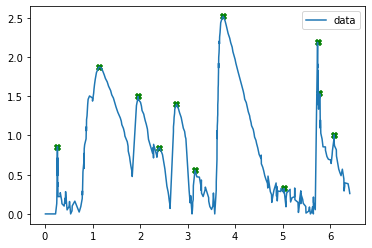

In [635]:
# Find peaks
# Data
plt.plot(xdat, ydat, label='data')
# Peaks
plt.scatter(xdat[peaks], ydat[peaks], marker='X', color='g')
# plt.vlines(x=xdat[peaks], ymin=ydat[peaks] - properties["prominences"],
#            ymax = ydat[peaks], color = "C1")
plt.legend(loc='upper right')
# plt.xlim(0., 1)
plt.show()

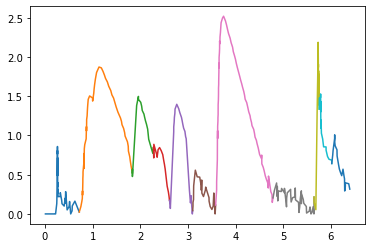

In [636]:
# Splitting data manually
upper_bounds = [42, 26, 13, 10, 17, 19, 50, 31, 15, 23, -1]
ranges = []
for id_up, upper_bound in enumerate(upper_bounds):
    if id_up == 0:
        ranges.append([0, upper_bounds[0]])
    elif id_up == len(upper_bounds)-1:
        ranges.append([ranges[-1][1]-1, -1])
    else:
        ranges.append([ranges[-1][1]-1, peaks[id_up]+upper_bound])
# Plot
for range_set in ranges:
    plt.plot(xdat[range_set[0]:range_set[1]], ydat[range_set[0]:range_set[1]])

In [649]:
# Fitting
def gamma_func(x, amp, mean, sd):
    distro = construct_pdf(
        {"class": "Gamma",
        "mean": mean,
        "sd": sd
        })
    return distro.pdf(x) * amp
def cauchy(x, loc, scale, k):
    rv = stats.cauchy(loc, scale)
    res = []
    for xid in x:
        if xid < 3.6:
            res.append(0.)
        elif xid <= loc:
            res.append(rv.pdf(xid))
        else:
            res.append(rv.pdf(loc) - k * (xid-loc))
    res = np.array(res)
    return res
def cauchy_pos(x, loc, scale, k):
    tmp = cauchy(x, loc, scale, k)
    tmp[tmp < 0.] = 0.
    return tmp

In [650]:
# Fit
popt_list = []
for idrange, range_set in enumerate(ranges):
    if idrange == 0:
        popt, _ = curve_fit(gamma_func,
                        xdat[range_set[0]:range_set[1]],
                        ydat[range_set[0]:range_set[1]])
    # Subtract previous fit
    elif idrange in [6]:
        popt, _ = curve_fit(
            cauchy,
            xdat[range_set[0]:range_set[1]],
            ydat[range_set[0]:range_set[1]] -
            gamma_func(xdat[range_set[0]:range_set[1]],
            *popt_list[idrange-1]))
    elif idrange in [7]:
        popt, _ = curve_fit(
            gamma_func,
            xdat[range_set[0]:range_set[1]],
            ydat[range_set[0]:range_set[1]] -
            cauchy_pos(xdat[range_set[0]:range_set[1]],
            *popt_list[idrange-1]))
    else:
        popt, _ = curve_fit(
            gamma_func,
            xdat[range_set[0]:range_set[1]],
            ydat[range_set[0]:range_set[1]] -
            gamma_func(xdat[range_set[0]:range_set[1]],
            *popt_list[idrange-1]))
    popt_list.append(popt)

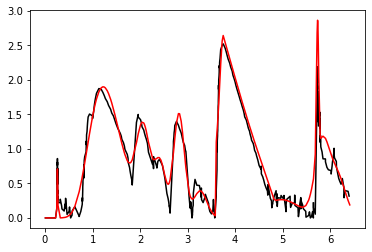

In [651]:
# Plotting fits
total = []
for idrange, range_set in enumerate(ranges):
        if idrange in [6]:
                total.append(cauchy_pos(xdat, *popt_list[idrange]))
        else:
                total.append(gamma_func(xdat, *popt_list[idrange]))
total = np.sum(total, axis=0)
for idrange, range_set in enumerate(ranges):
        plt.plot(
                xdat[range_set[0]:range_set[1]],
                ydat[range_set[0]:range_set[1]],
                color='k',
        )
plt.plot(xdat, total, color='r')